In this notebook we will calibrate forward model from monochromator measurements, and make dataset. 

In [181]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel
from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass, shift

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
import h5py
file = h5py.File('/project/agdoepp/Howard/microlens_dataset_1.h5','r')

dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/microlens_18012024_new/'

def extract_data(file, indices):
    m1 = torch.tensor(file['m1'][indices]) 
    f = torch.tensor(file['f'][indices])
    p1 = torch.tensor(file['p1'][indices])
    f_peak_locs = torch.tensor(file['f_peak_locs'][indices])
    intensity = torch.tensor(file['intensity'][indices])
    phase_x = torch.tensor(file['phase_x'][indices])
    phase_y = torch.tensor(file['phase_y'][indices])

    # f_peak_locs = (f_peak_locs - torch.tensor([0, 900])[None]) / (torch.tensor([700, 1600]) - torch.tensor([0, 1000]))[None]

    return m1, p1, f, f_peak_locs, intensity, phase_x, phase_y


std_main_funda = torch.load(dir+'std_main_funda.pt')
std_main_plus1 = torch.load(dir+'std_main_plus1.pt')
std_main_minus1 = torch.load(dir+'std_main_minus1.pt')

kernel = torch.load(dir+'microlens_kernel.pt')

grating_modulation_m1 = torch.load(dir+'microlens_grating_modulation_m1.pt').to(device) #for multiplying the image[...,:750]
grating_modulation_p1 = torch.load(dir+'microlens_grating_modulation_p1.pt').to(device) #for multiplying the image[...,-750:]

n_wl = std_main_funda.shape[1]



In [183]:
from scipy.ndimage import center_of_mass

abs_dispersion_minus1 = np.zeros_like(std_main_funda)
abs_dispersion_plus1 = np.zeros_like(std_main_funda)

for i in range(n_wl):
    com_m1 = center_of_mass(kernel[0,i,:,:750].cpu().numpy()) + np.array([0, 0])
    com_p1 = center_of_mass(kernel[0,i,:,1800:].cpu().numpy()) + np.array([0, 1800])
    com_f = center_of_mass(kernel[0,i,:,750:1800].cpu().numpy()) + np.array([0, 750])


    abs_dispersion_minus1[:,i] = com_m1 - com_f
    abs_dispersion_plus1[:,i] = com_p1 - com_f



In [185]:
abs_dispersion_minus1

array([[ 9.38070744e-01,  9.59291545e-01,  7.94588774e-01,
         7.10657895e-01,  5.82507730e-01,  5.02746865e-01,
         3.51074457e-01,  1.17770992e-01,  9.64438424e-01,
         8.21327895e-01,  6.51810884e-01,  5.20491198e-01,
         3.78461421e-01,  1.03703450e-01,  9.71218972e-01,
         8.05521667e-01,  6.39181241e-01,  4.67707530e-01,
         1.51270993e-01,  6.77126402e-04,  8.32931836e-01,
         6.92564607e-01,  5.35282090e-01,  3.93841498e-01,
         1.21267542e-01,  9.65229020e-01,  8.17812204e-01,
         7.04927397e-01,  5.67450598e-01,  4.05500509e-01,
         1.06797971e-01,  9.38526310e-01,  7.71548435e-01,
         6.17327884e-01,  3.30876738e-01,  1.53740300e-01,
         8.48598359e-03,  8.56733939e-01,  7.21769124e-01,
         5.61292246e-01,  2.85538122e-01,  1.23079119e-01,
         9.55212161e-01,  7.66104400e-01,  5.89747816e-01,
         4.22134675e-01,  1.07414369e-01,  9.13899258e-01,
         7.15078562e-01,  5.41295335e-01,  4.32968542e-0

#### We have the locations of the peaks in the fundamental. We also have the absolute dispersion factors for their corresponding places in +-1

In [150]:
distances_to_center = abs(abs_dispersion_minus1[1,n_wl//2] - abs_dispersion_minus1[1,0]), abs(abs_dispersion_minus1[1,n_wl//2] - abs_dispersion_minus1[1,-1]), abs(abs_dispersion_plus1[1,n_wl//2] - abs_dispersion_plus1[1,0]), abs(abs_dispersion_plus1[1,n_wl//2] - abs_dispersion_plus1[1,-1])

box_size = np.ceil(np.max(distances_to_center)).astype(int)

print(np.max(distances_to_center), np.std(distances_to_center))


87.78949160501361 0.740830240725908


### Now we have the locations of the boxes. Lets try to recover the spectra.
Pull out the +1/-1 and fundamental for one peak.  

In [161]:
peakno = 0

Y_m1, Y_p1, Y_f, f_peak_locs, intensity, phase_x_true, phase_y_true =  extract_data(file, [peakno])

Y_m1 = Y_m1.float().to(device)
Y_p1 = Y_p1.float().to(device)
Y_f = Y_f.float().to(device)




print(Y_f.sum()/ Y_m1.sum(), Y_f.sum()/ Y_p1.sum())

#send everything to torch.

x_m1 = torch.arange(-Y_m1.shape[1]//2+1,Y_m1.shape[1]//2+1).to(device) #- m1_rounding_correction[peakno,0]
y_m1 = torch.arange(-Y_m1.shape[2]//2+1,Y_m1.shape[2]//2+1).to(device) #- m1_rounding_correction[peakno,1]

x_m1,y_m1 = torch.meshgrid(x_m1,y_m1)

x_p1 = torch.arange(-Y_p1.shape[1]//2+1,Y_p1.shape[1]//2+1).to(device) #- p1_rounding_correction[peakno,0]
y_p1 = torch.arange(-Y_p1.shape[2]//2+1,Y_p1.shape[2]//2+1).to(device)# - p1_rounding_correction[peakno,1]
x_p1,y_p1 = torch.meshgrid(x_p1,y_p1)

x_f = torch.arange(-Y_f.shape[1]//2+1,Y_f.shape[1]//2+1).to(device) #- f_rounding_correction[peakno,0]
y_f = torch.arange(-Y_f.shape[2]//2+1,Y_f.shape[2]//2+1).to(device) #- f_rounding_correction[peakno,1]
x_f,y_f = torch.meshgrid(x_f,y_f)


# intensities = nn.Parameter(torch.ones(len(intensity[0])).to(device))
intensities = nn.Parameter(intensity[0].clone().to(device))
phase_x = nn.Parameter(torch.zeros(len(intensity[0])).to(device))
phase_y = nn.Parameter(torch.zeros(len(intensity[0])).to(device))

# phase_x.requires_grad = False
# phase_y.requires_grad = False


rel_dispersion_minus1 = abs_dispersion_minus1 - abs_dispersion_minus1[:,n_wl//2][:,None]
rel_dispersion_plus1 = abs_dispersion_plus1 - abs_dispersion_plus1[:,n_wl//2][:,None]

dispersion_minus1 = torch.tensor(rel_dispersion_minus1).float().to(device);
dispersion_plus1 = torch.tensor(rel_dispersion_plus1).float().to(device);

std_main_funda = torch.tensor(std_main_funda).float().to(device);
std_main_minus1 = torch.tensor(std_main_minus1).float().to(device);
std_main_plus1 = torch.tensor(std_main_plus1).float().to(device);

minus1_positions = (f_peak_locs[0][:,None] + abs_dispersion_minus1[:,:]).int()
plus1_positions = (f_peak_locs[0][:,None] + abs_dispersion_plus1[:,:]).int() 

plus1_positions[1] -= kernel.shape[3] - 750

intensity_modulation_minus1 = torch.stack([grating_modulation_m1[0,i,minus1_positions[0,i],minus1_positions[1,i]] for i in range(n_wl)]).float().to(device);
intensity_modulation_plus1 = torch.stack([grating_modulation_p1[0,i,plus1_positions[0,i],plus1_positions[1,i]] for i in range(n_wl)]).float().to(device);
intensity_modulation_plus1 = torch.tensor(intensity_modulation_plus1).float().to(device);

tensor(1.6976, device='cuda:2') tensor(1.5837, device='cuda:2')


/tmp/user/25186/ipykernel_3443493/4152221540.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_main_funda = torch.tensor(std_main_funda).float().to(device);
/tmp/user/25186/ipykernel_3443493/4152221540.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_main_minus1 = torch.tensor(std_main_minus1).float().to(device);
/tmp/user/25186/ipykernel_3443493/4152221540.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_main_plus1 = torch.tensor(std_main_plus1).float().to(device);
/tmp/user/25186/ipykernel_3443493/4152221540.py:56

In [162]:
minus1_positions

tensor([[412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412, 412,
         412, 412, 412, 412, 413, 413, 413, 413, 413, 413],
        [191, 190, 189, 188, 187, 186, 184, 183, 182, 181, 180, 179, 178, 177,
         175, 174, 173, 172, 171, 170, 168, 167, 166, 165, 164, 162, 16

In [163]:
def simulate_dispersion(intensities, phase_x, phase_y, stds, dispersions, intensity_modulation, x, y):
    
    dispersion = intensities[:,None,None] * intensity_modulation[:,None,None] * torch.exp(-(x[None] - phase_x[:,None,None] - dispersions[0][:,None,None])**2 / (2 * stds[0][:,None,None]**2) - (y[None] - phase_y[:,None,None] - dispersions[1][:,None,None])**2 / (2 * stds[1][:,None,None]**2))
    return dispersion

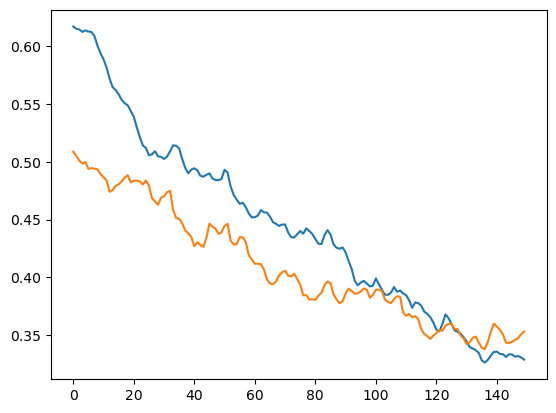

In [164]:
plt.plot(intensity_modulation_minus1.cpu())
plt.plot(intensity_modulation_plus1.cpu())



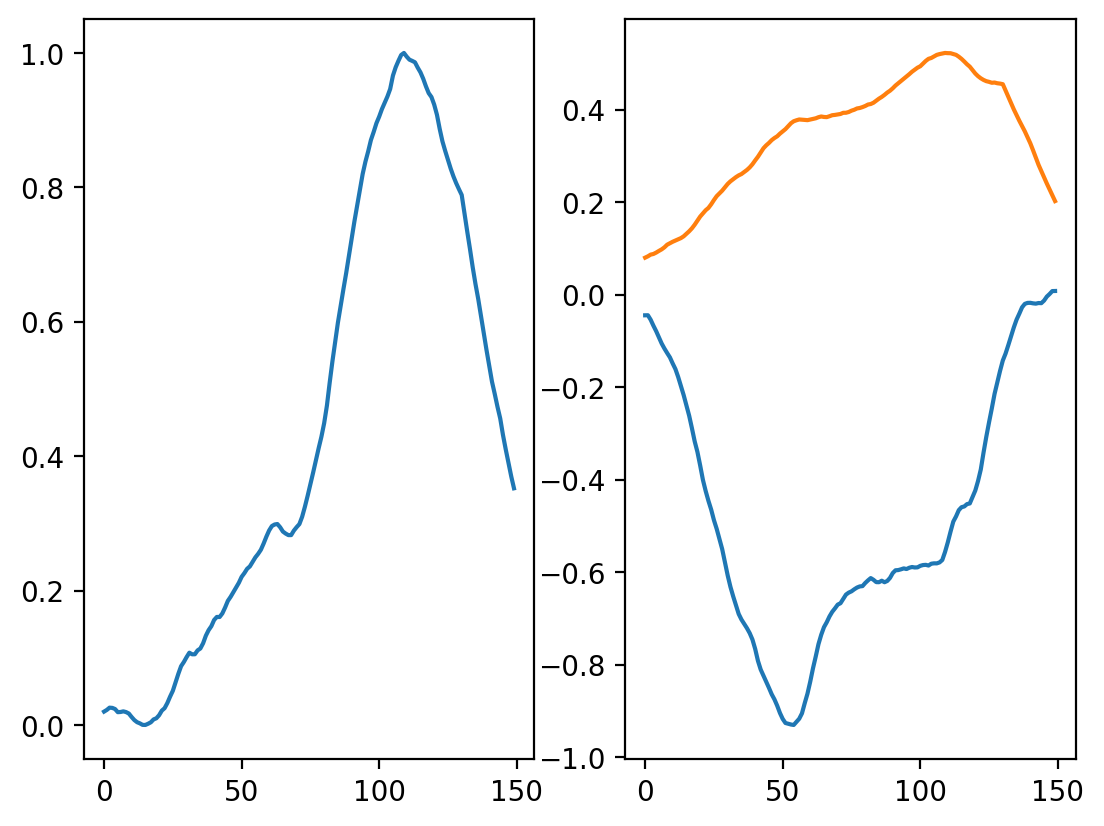

In [165]:
fig,ax = plt.subplots(1,2,dpi=200)
ax[0].plot(intensity[0].cpu())
ax[1].plot(phase_x_true[0].cpu())
ax[1].plot(phase_y_true[0].cpu())

Text(0.5, 1.0, 'pred-true')

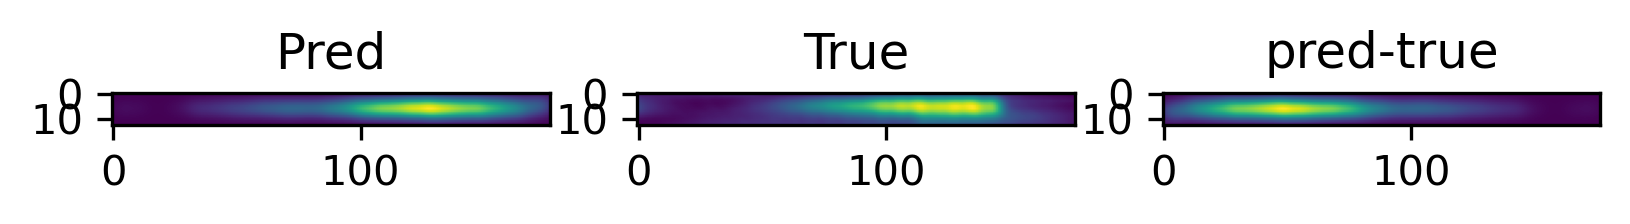

In [168]:
fig,ax = plt.subplots(1,3,dpi=300)
ax[0].imshow(torch.sum(simulate_dispersion(intensities, phase_x, phase_y, std_main_minus1, -dispersion_minus1, intensity_modulation_minus1, x_m1, y_m1),dim=0).detach().cpu()); ax[0].set_title('Pred')
ax[1].imshow(Y_m1[0].cpu()); ax[1].set_title('True')
ax[2].imshow(torch.sum(simulate_dispersion(intensities, phase_x, phase_y, std_main_minus1, dispersion_minus1, intensity_modulation_minus1, x_m1, y_m1),dim=0).detach().cpu() - Y_m1[0].cpu()); ax[2].set_title('pred-true')

# for i,wl in enumerate([10,30,50,70,90]):
#     pred = simulate_dispersion(intensities, phase_x, phase_y, std_main_minus1, dispersion_minus1, intensity_modulation_minus1, x_m1, y_m1)[wl].detach().cpu()
#     true = cube[wl,center_wl_peak_positions_m1[peakno,0]-border:center_wl_peak_positions_m1[peakno,0]+border+1,center_wl_peak_positions_m1[peakno,1]-box_size:center_wl_peak_positions_m1[peakno,1]+box_size+1]

#     pred = pred / pred.max() * true.max()

#     diff = pred - true
#     ax[i+1,0].imshow(pred,cmap='RdBu')
#     ax[i+1,1].imshow(true,cmap='RdBu')
#     ax[i+1,2].imshow(diff,cmap='RdBu')



Text(0.5, 1.0, 'pred-true')

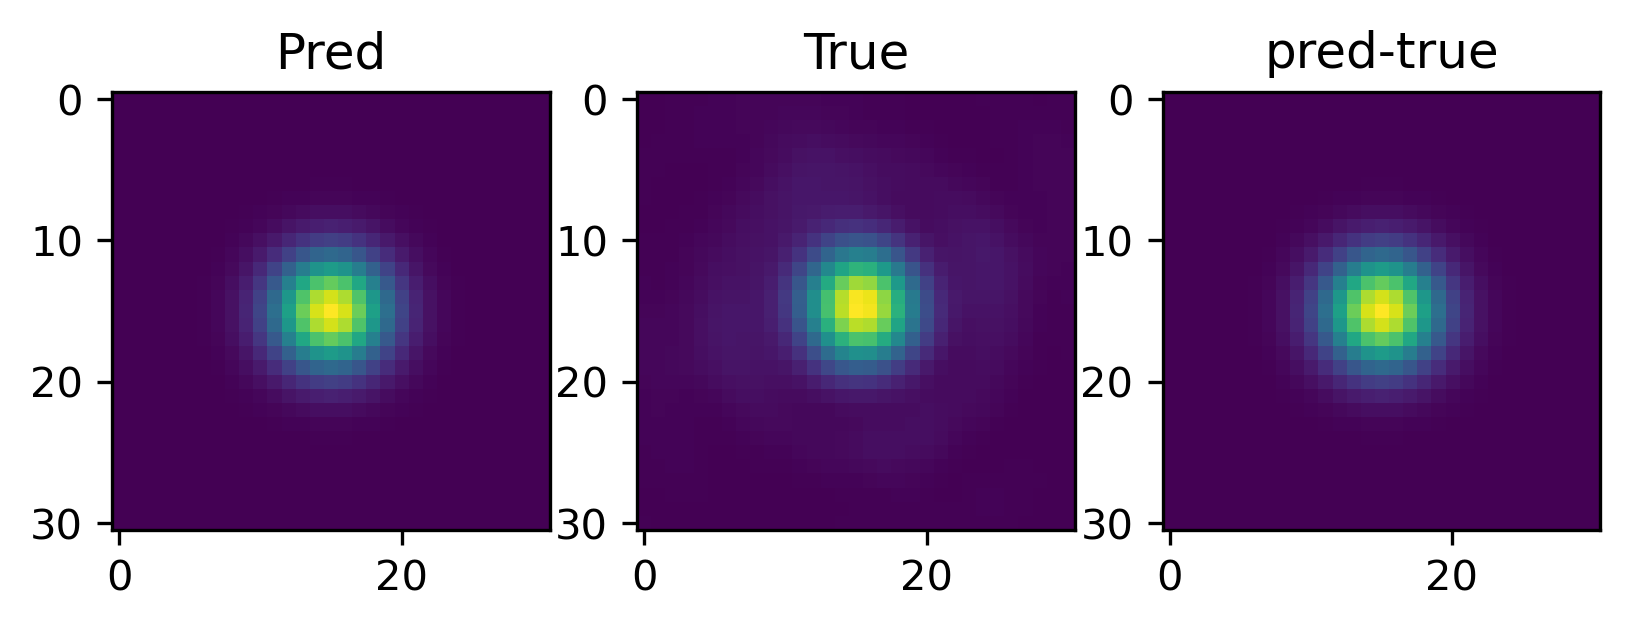

In [117]:
fig,ax = plt.subplots(1,3,dpi=300)
ax[0].imshow(torch.sum(simulate_dispersion(intensities, phase_x, phase_y, std_main_funda, torch.zeros_like(dispersion_plus1), torch.ones_like(intensity_modulation_plus1), x_f, y_f),dim=0).detach().cpu()); ax[0].set_title('Pred')
ax[1].imshow(Y_f[0].cpu()); ax[1].set_title('True')
ax[2].imshow(torch.sum(simulate_dispersion(intensities, phase_x, phase_y, std_main_funda, torch.zeros_like(dispersion_plus1), torch.ones_like(intensity_modulation_plus1), x_f, y_f),dim=0).detach().cpu()); ax[2].set_title('pred-true')


In [169]:
optimizer = torch.optim.Adam([intensities, phase_x, phase_y], lr=0.001)
loss_fn = torch.nn.MSELoss()

store_loss = []
store_true_loss = []

def second_derivative(oned_array):
    # first_deriv = torch.gradient(oned_array)[0]
    # second_derivative = torch.gradient(first_deriv)[0]

    # deriv_xx = (1/90)*torch.roll(oned_array,3) -(3/20)*torch.roll(oned_array,2) + (3/2)*torch.roll(oned_array,1) - (49/18) * oned_array + (3/2)*torch.roll(oned_array,-1) - (3/20)*torch.roll(oned_array,-2) + (1/90)*torch.roll(oned_array,-3)
    deriv_xx = torch.roll(oned_array,1) - (2) * oned_array + torch.roll(oned_array,-1)
    
    return deriv_xx[3:-3]

# Y_f_nonflat = cube[:,center_wl_peak_positions_f[peakno,0]-f_border:center_wl_peak_positions_f[peakno,0]+f_border+1,center_wl_peak_positions_f[peakno,1] - f_border:center_wl_peak_positions_f[peakno,1]+f_border+1].to(device)


In [178]:
epochs = 10000

for i in range(epochs):
    optimizer.zero_grad()

    y_pred_m1 = torch.sum(simulate_dispersion(intensities, phase_x, phase_y, std_main_minus1, -dispersion_minus1, intensity_modulation_minus1, x_m1, y_m1),dim=0)
    y_pred_p1 = torch.sum(simulate_dispersion(intensities, phase_x, phase_y, std_main_plus1, -dispersion_plus1, intensity_modulation_plus1, x_p1, y_p1),dim=0)
    y_pred_f = torch.sum(simulate_dispersion(intensities, phase_x, phase_y, std_main_funda, torch.zeros_like(dispersion_plus1), torch.ones_like(intensity_modulation_plus1), x_f, y_f),dim=0)

    
    reg_intensity = torch.sum(second_derivative(intensities)**2)
    reg_phase = torch.sum(second_derivative(phase_x)**2) + torch.sum(second_derivative(phase_y)**2)

    mse = loss_fn(y_pred_m1, Y_m1) * y_pred_m1.numel() + loss_fn(y_pred_p1, Y_p1) * y_pred_p1.numel()  + loss_fn(y_pred_f, Y_f) * y_pred_f.numel()
    # mse = loss_fn(y_pred_f, Y_f) * y_pred_f.numel()
    reg = reg_intensity + reg_phase 

    loss = mse +  reg * 5e3

    
    # y_pred_f_nonflat = simulate_dispersion(intensities, phase_x, phase_y, std_main_funda, torch.zeros_like(dispersion_plus1), torch.ones_like(intensity_modulation_plus1), x_f, y_f)
    # true_loss = loss_fn(y_pred_f_nonflat, Y_f_nonflat) 

    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f'mse: {mse.item():.5g},  reg: {reg.item():.5g}, ',end='\r')
    store_loss.append(loss.item())
    # store_true_loss.append(true_loss.item())

    with torch.no_grad():
        intensities.clamp_(min=0)

plt.plot(np.log10(store_loss))

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 13, 177])) that is different to the input size (torch.Size([13, 177])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 31, 31])) that is different to the input size (torch.Size([31, 31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

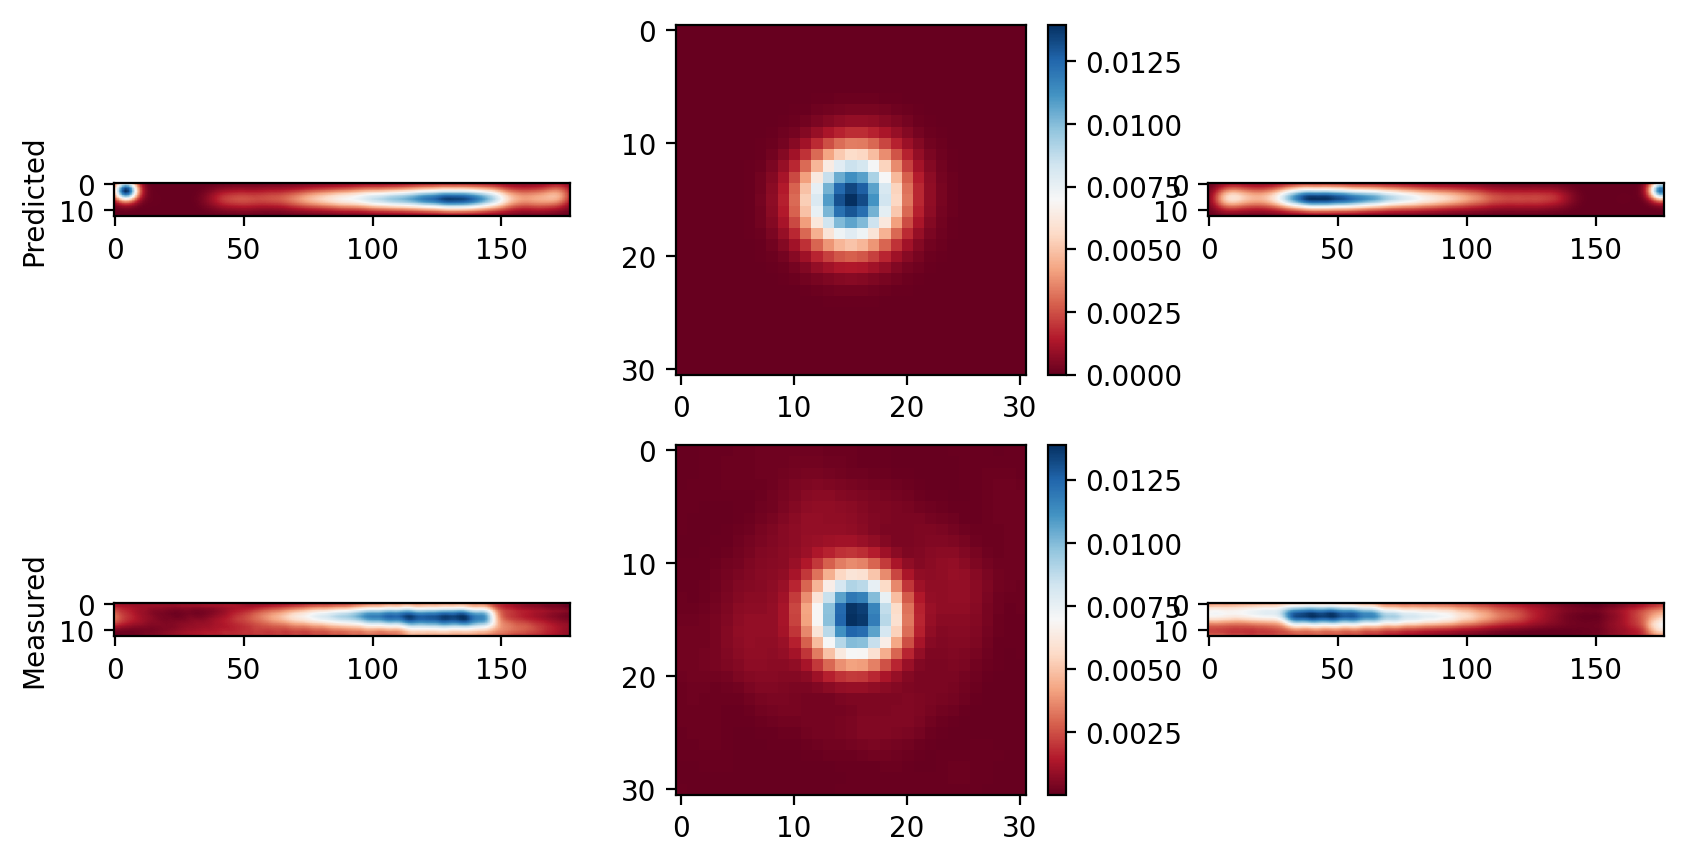

In [179]:
fig,ax = plt.subplots(2,3,figsize = (10,5),dpi=200)
ax[0,0].imshow(y_pred_m1.detach().cpu(),cmap='RdBu');ax[0,0].set_ylabel('Predicted')
ax[1,0].imshow(Y_m1[0].detach().cpu(),cmap='RdBu'); ax[1,0].set_ylabel('Measured')
test1 = ax[0,1].imshow(y_pred_f.detach().cpu(),cmap='RdBu')
test2 = ax[1,1].imshow(Y_f[0].detach().cpu(),cmap='RdBu')
fig.colorbar(test1, ax=ax[0,1])
fig.colorbar(test2, ax=ax[1,1])
ax[0,2].imshow(y_pred_p1.detach().cpu(),cmap='RdBu')
ax[1,2].imshow(Y_p1[0].detach().cpu(),cmap='RdBu')

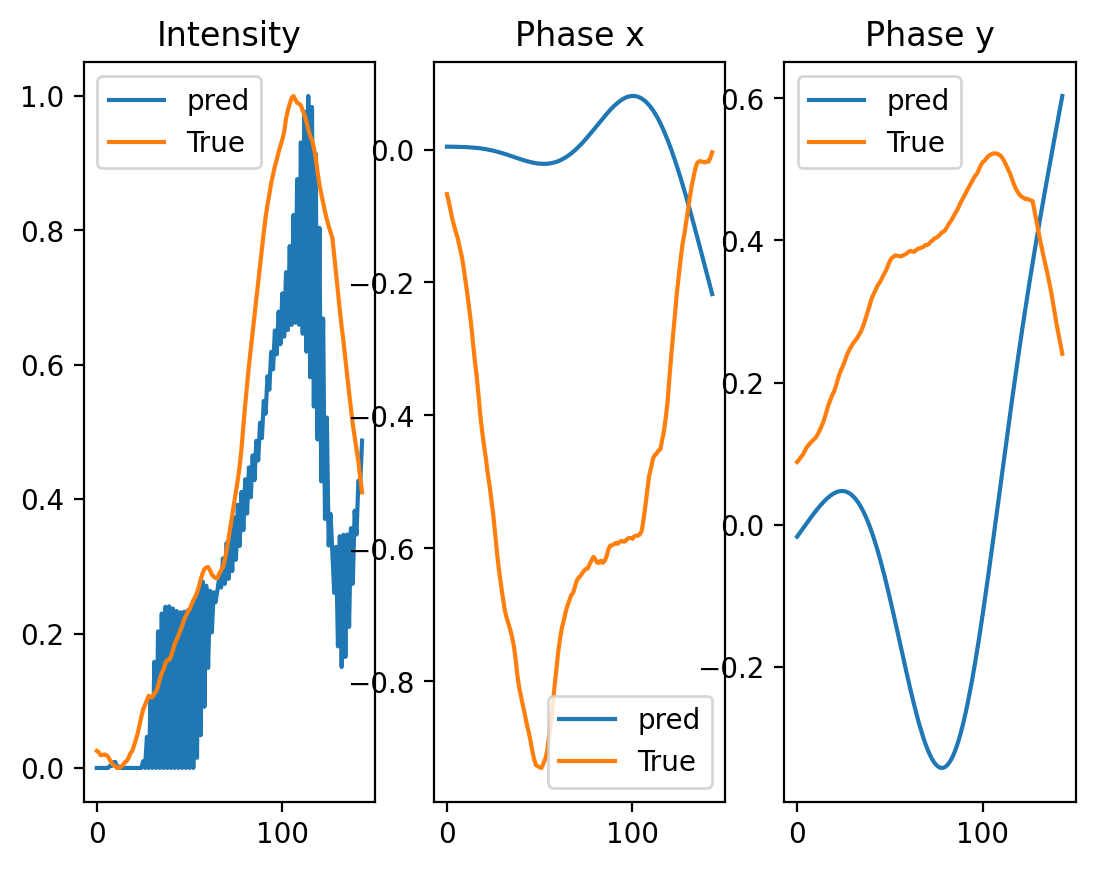

In [180]:
fig,ax = plt.subplots(1,3,dpi=200)

normed_intensities = intensities.clone()
normed_intensities[3:-3] /= normed_intensities[3:-3].max()

ax[0].plot(normed_intensities.cpu().detach()[3:-3],label='pred')
ax[0].plot(intensity[0,3:-3],label='True')
ax[0].legend()
ax[0].set_title('Intensity')

ax[1].plot(phase_x.cpu().detach()[3:-3],label='pred'); ax[1].set_title('Phase x')
ax[1].plot(phase_x_true[0,3:-3],label='True')
ax[1].legend()

ax[2].plot(phase_y.cpu().detach()[3:-3],label='pred'); ax[2].set_title('Phase y')
ax[2].plot(phase_y_true[0,3:-3],label='True')
ax[2].legend()

#### Lets see the error with the **cube**

In [142]:
Y_m1_nonflat = cube[:,center_wl_peak_positions_m1[peakno,0]-border:center_wl_peak_positions_m1[peakno,0]+border+1,center_wl_peak_positions_m1[peakno,1]-box_size:center_wl_peak_positions_m1[peakno,1]+box_size+1].to(device)
Y_p1_nonflat = cube[:,center_wl_peak_positions_p1[peakno,0]-border:center_wl_peak_positions_p1[peakno,0]+border+1,center_wl_peak_positions_p1[peakno,1]-box_size:center_wl_peak_positions_p1[peakno,1]+box_size+1].to(device)
Y_f_nonflat = cube[:,center_wl_peak_positions_f[peakno,0]-f_border:center_wl_peak_positions_f[peakno,0]+f_border+1,center_wl_peak_positions_f[peakno,1] - f_border:center_wl_peak_positions_f[peakno,1]+f_border+1].to(device)

y_pred_m1_nonflat = simulate_dispersion(intensities, phase_x, phase_y, std_main_minus1, dispersion_minus1, intensity_modulation_minus1, x_m1, y_m1)
y_pred_p1_nonflat = simulate_dispersion(intensities, phase_x, phase_y, std_main_plus1, dispersion_plus1, intensity_modulation_plus1, x_p1, y_p1)
y_pred_f_nonflat = simulate_dispersion(intensities, phase_x, phase_y, std_main_funda, torch.zeros_like(dispersion_plus1), torch.ones_like(intensity_modulation_plus1), x_f, y_f)

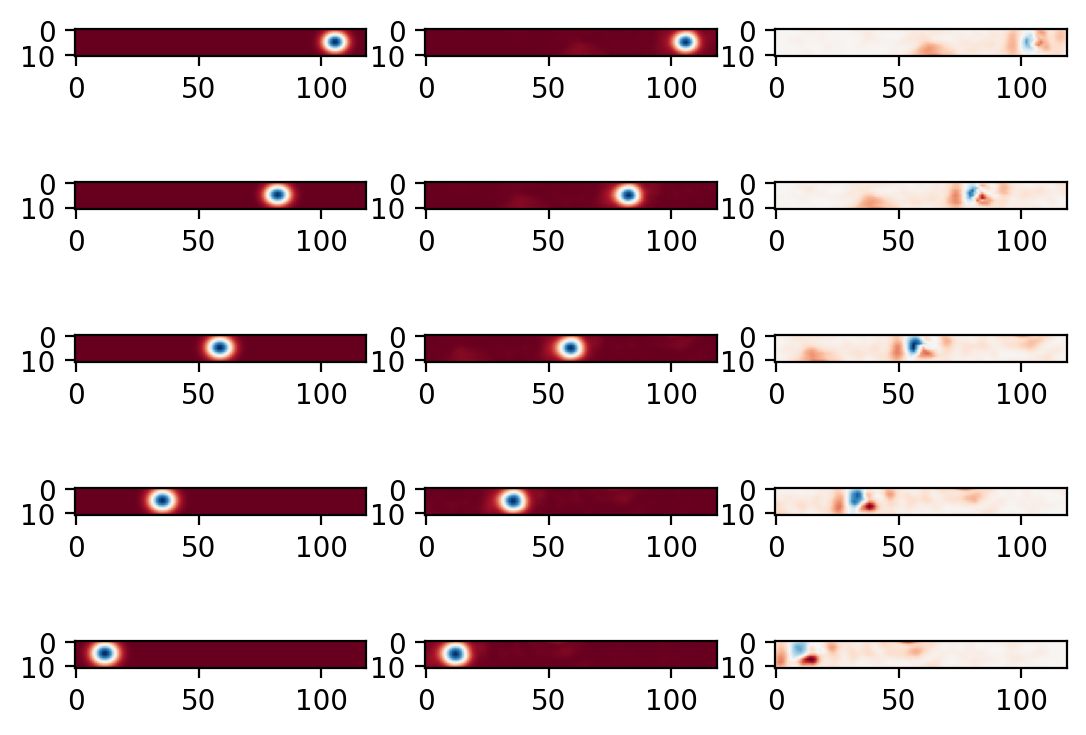

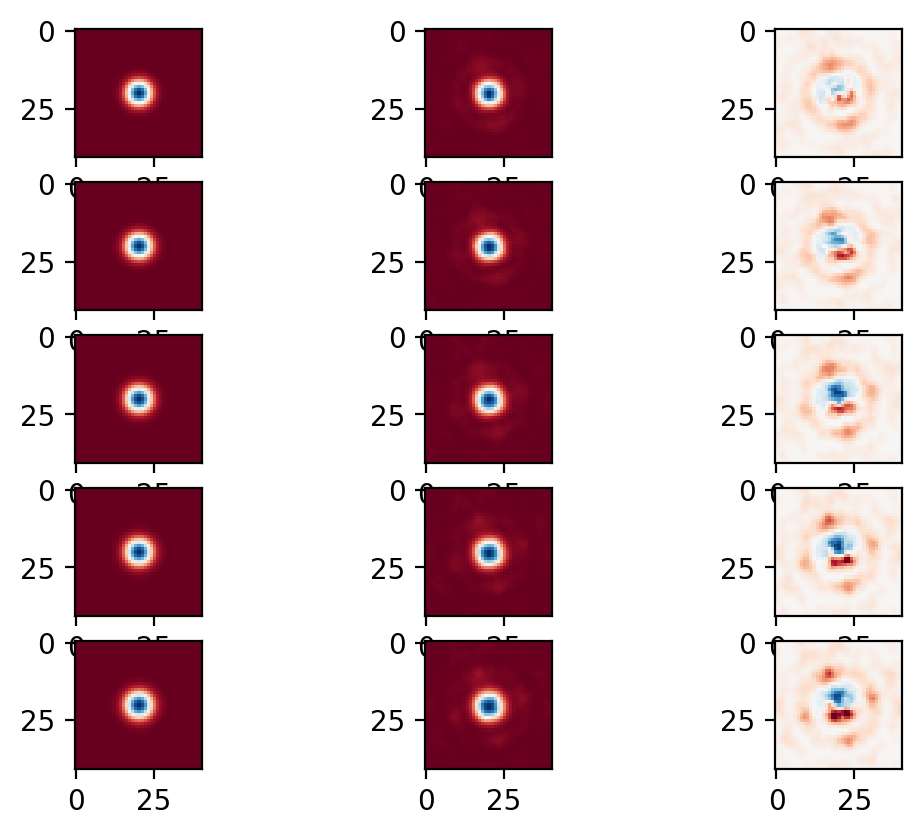

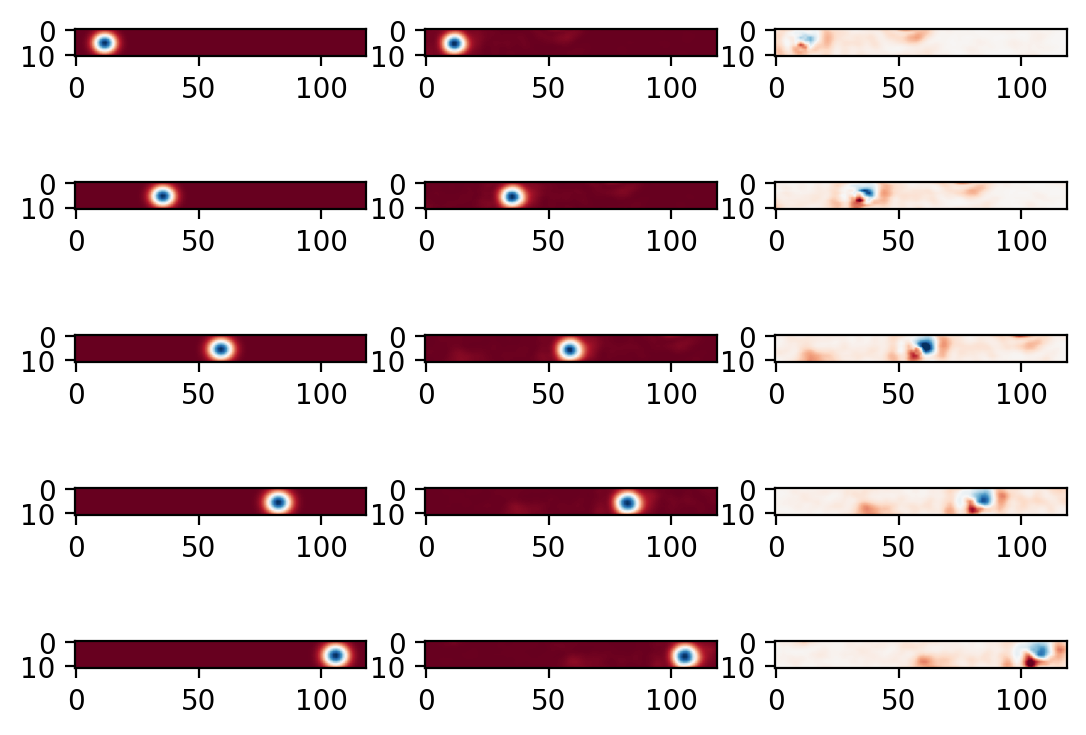

In [145]:
fig,ax = plt.subplots(5,3,dpi=200)
for i,wl in enumerate([10,30,50,70,90]):
    ax[i,0].imshow(y_pred_m1_nonflat[wl].detach().cpu(),cmap='RdBu')
    ax[i,1].imshow(Y_m1_nonflat[wl].detach().cpu(),cmap='RdBu')
    ax[i,2].imshow(y_pred_m1_nonflat[wl].detach().cpu() - Y_m1_nonflat[wl].detach().cpu(),vmax=0.1*Y_m1_nonflat[wl].max(),vmin=-0.1*Y_m1_nonflat[wl].max(),cmap='RdBu')

fig,ax = plt.subplots(5,3,dpi=200)
for i,wl in enumerate([10,30,50,70,90]):
    ax[i,0].imshow(y_pred_f_nonflat[wl].detach().cpu(),cmap='RdBu')
    ax[i,1].imshow(Y_f_nonflat[wl].detach().cpu(),cmap='RdBu')
    ax[i,2].imshow(y_pred_f_nonflat[wl].detach().cpu() - Y_f_nonflat[wl].detach().cpu(),vmax=0.1*Y_f_nonflat[wl].max(),vmin=-0.1*Y_f_nonflat[wl].max(),cmap='RdBu')

fig,ax = plt.subplots(5,3,dpi=200)
for i,wl in enumerate([10,30,50,70,90]):
    ax[i,0].imshow(y_pred_p1_nonflat[wl].detach().cpu(),cmap='RdBu')
    ax[i,1].imshow(Y_p1_nonflat[wl].detach().cpu(),cmap='RdBu')
    ax[i,2].imshow(y_pred_p1_nonflat[wl].detach().cpu() - Y_p1_nonflat[wl].detach().cpu(),vmax=0.1*Y_p1_nonflat[wl].max(),vmin=-0.1*Y_p1_nonflat[wl].max(),cmap='RdBu')

In [146]:
Y_f_nonflat.max()

tensor(0.2386, device='cuda:0')

In [147]:
loss_fn(Y_m1_nonflat, y_pred_m1_nonflat) , loss_fn(Y_f_nonflat, y_pred_f_nonflat) 

(tensor(1.5473e-06, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(9.1099e-06, device='cuda:0', grad_fn=<MseLossBackward0>))

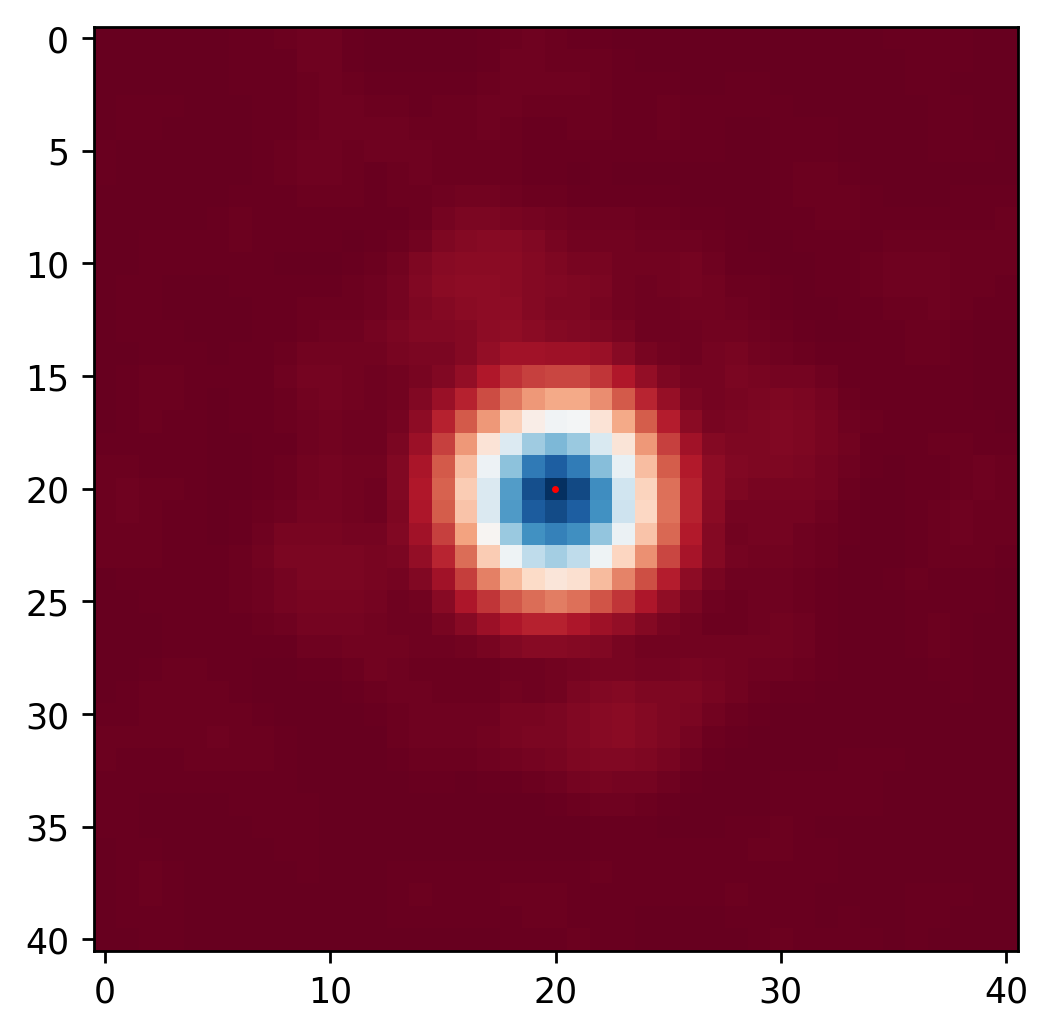

In [158]:
wl=50
plt.figure(dpi=250)
pred_com = center_of_mass(y_pred_f_nonflat[wl].detach().cpu().numpy())
plt.imshow(Y_f_nonflat[wl].detach().cpu(),cmap='RdBu')
plt.plot(pred_com[1],pred_com[0],'ro',markersize=1)

## Test the HDR process... 

In [127]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/microlens_15012024/'

files = os.listdir(dir)

hdr = np.load(dir+files[1])
nohdr = np.load(dir+files[0])

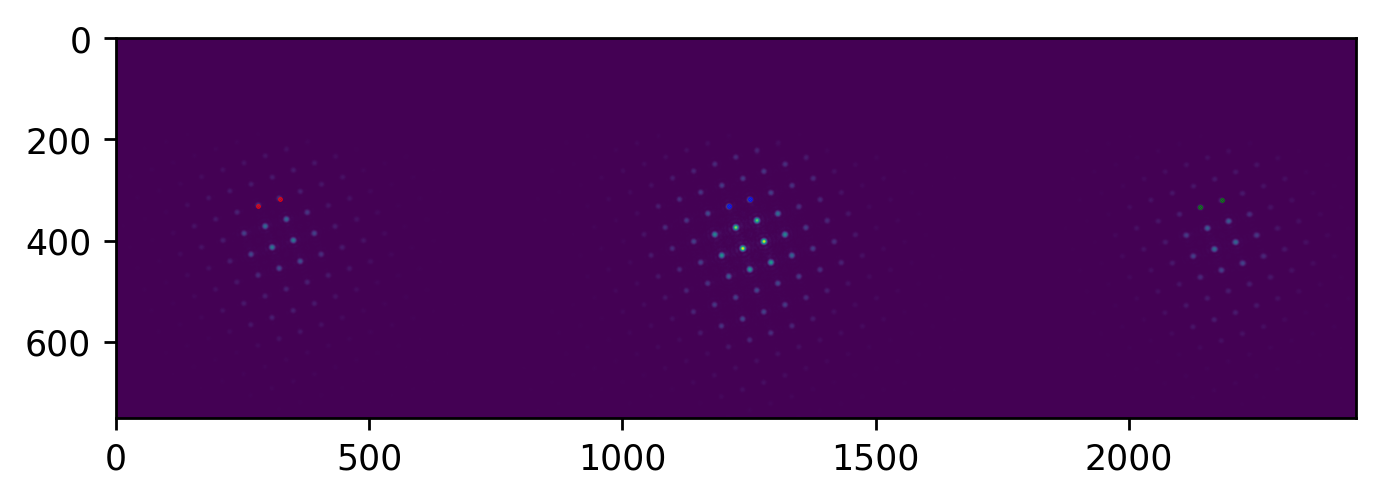

In [128]:
relative_peak_locations = peak_local_max(hdr[:,1000:1500],threshold_rel=0.1,min_distance=10)
all_funda_peaks = relative_peak_locations + np.array([0,1000])
relative_peak_locations -= relative_peak_locations[0]

minus1_loc = peak_local_max(hdr[:,:600],num_peaks=1)[0] 

plus1_loc = peak_local_max(hdr[:,1800:],num_peaks=1)[0] + np.array([0,1800])

all_minus1_peaks = minus1_loc[None,:] + relative_peak_locations
all_plus1_peaks = plus1_loc[None,:] + relative_peak_locations


peak_nos = [10,11]
plt.figure(dpi=250)
plt.imshow(hdr)
plt.scatter(all_minus1_peaks[peak_nos,1],all_minus1_peaks[peak_nos,0],c='r',s=0.1)
plt.scatter(all_plus1_peaks[peak_nos,1],all_plus1_peaks[peak_nos,0],c='g',s=0.1)
plt.scatter(all_funda_peaks[peak_nos,1],all_funda_peaks[peak_nos,0],c='b',s=0.1)

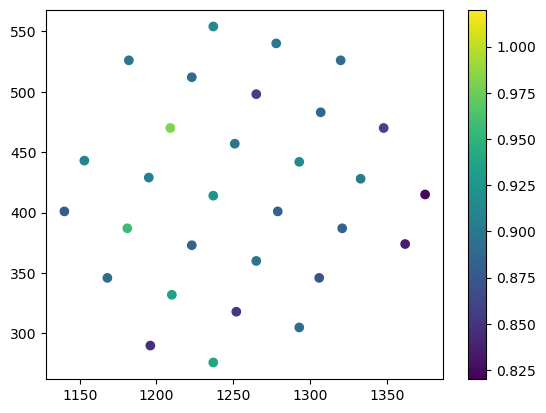

In [129]:
border = 13

no_peaks = 30
save_m1_over_f = np.zeros(no_peaks)
save_p1_over_m1 = np.zeros(no_peaks)

for peakno in range(no_peaks):
    intens_m1 = hdr[all_minus1_peaks[peakno,0]-border:all_minus1_peaks[peakno,0]+border+1,all_minus1_peaks[peakno,1]-border:all_minus1_peaks[peakno,1]+border+1]
    intens_p1 = hdr[all_plus1_peaks[peakno,0]-border:all_plus1_peaks[peakno,0]+border+1,all_plus1_peaks[peakno,1]-border:all_plus1_peaks[peakno,1]+border+1]
    intens_f = hdr[all_funda_peaks[peakno,0]-border:all_funda_peaks[peakno,0]+border+1,all_funda_peaks[peakno,1]-border:all_funda_peaks[peakno,1]+border+1]

    save_m1_over_f[peakno] = intens_m1.sum() / intens_f.sum()
    save_p1_over_m1[peakno] = intens_p1.sum() / intens_m1.sum()

    # print(intens_f.sum(),(intens_m1.sum() / intens_f.sum()), intens_p1.sum() / intens_f.sum() , intens_p1.sum()/ intens_m1.sum())

plt.scatter(all_funda_peaks[np.arange(no_peaks),1],all_funda_peaks[np.arange(no_peaks),0], c=save_p1_over_m1,vmax=1.02,vmin=0.82)
plt.colorbar()

In [119]:
print(save_p1_over_m1)

[0.9235854  0.88217516 0.88438578 0.89673873 0.91545588 0.8985736
 0.90677237 0.9564112  0.88181811 0.87176749 0.93466759 0.85266062
 0.90293282 0.98104621 0.88988403 0.91468926 0.85749384 0.88636884
 0.89911745 0.87771375 0.89076568 0.89006743 0.90997321 0.83591526
 0.88962439 0.84517544 0.89883203 0.86190711 0.82484715 0.9373992 ]


0.981046206486596
0.9245531885322579
0.8359152567981397


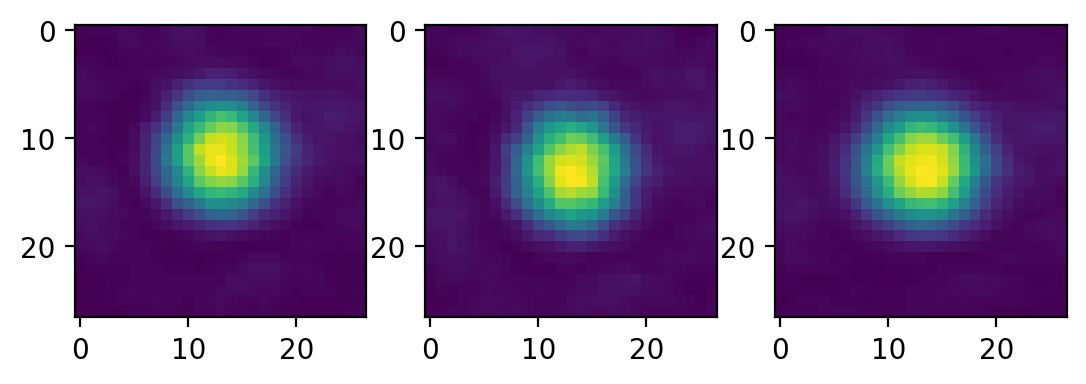

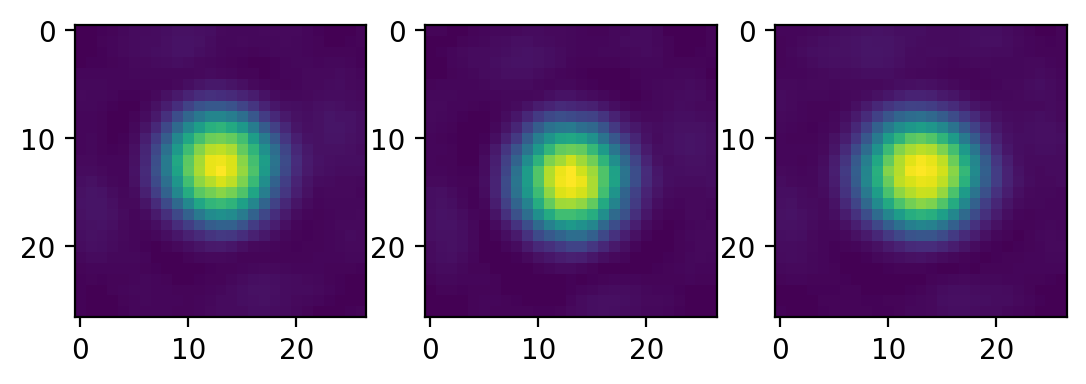

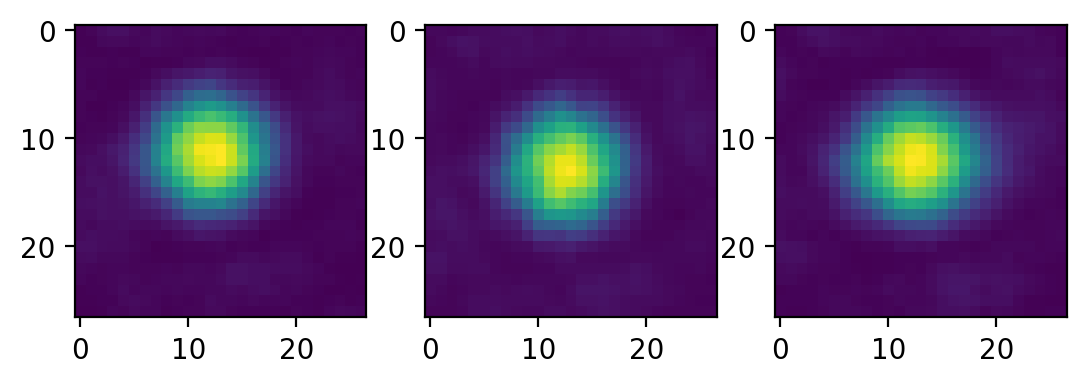

In [134]:
peakno = 13

intens_m1 = hdr[all_minus1_peaks[peakno,0]-border:all_minus1_peaks[peakno,0]+border+1,all_minus1_peaks[peakno,1]-border:all_minus1_peaks[peakno,1]+border+1].copy()
intens_p1 = hdr[all_plus1_peaks[peakno,0]-border:all_plus1_peaks[peakno,0]+border+1,all_plus1_peaks[peakno,1]-border:all_plus1_peaks[peakno,1]+border+1].copy()
intens_f = hdr[all_funda_peaks[peakno,0]-border:all_funda_peaks[peakno,0]+border+1,all_funda_peaks[peakno,1]-border:all_funda_peaks[peakno,1]+border+1].copy()

intens_m1[intens_m1<intens_m1.max()/100] = 0
intens_p1[intens_p1<intens_p1.max()/100] = 0
intens_f[intens_f<intens_f.max()/100] = 0


print(intens_p1.sum()/ intens_m1.sum())
fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(intens_m1)
ax[1].imshow(intens_f)
ax[2].imshow(intens_p1)

peakno = 0# 12

intens_m1 = hdr[all_minus1_peaks[peakno,0]-border:all_minus1_peaks[peakno,0]+border+1,all_minus1_peaks[peakno,1]-border:all_minus1_peaks[peakno,1]+border+1].copy()
intens_p1 = hdr[all_plus1_peaks[peakno,0]-border:all_plus1_peaks[peakno,0]+border+1,all_plus1_peaks[peakno,1]-border:all_plus1_peaks[peakno,1]+border+1].copy()
intens_f = hdr[all_funda_peaks[peakno,0]-border:all_funda_peaks[peakno,0]+border+1,all_funda_peaks[peakno,1]-border:all_funda_peaks[peakno,1]+border+1].copy()

intens_m1[intens_m1<intens_m1.max()/100] = 0
intens_p1[intens_p1<intens_p1.max()/100] = 0
intens_f[intens_f<intens_f.max()/100] = 0


print(intens_p1.sum()/ intens_m1.sum())

fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(intens_m1)
ax[1].imshow(intens_f)
ax[2].imshow(intens_p1)



peakno = 23

intens_m1 = hdr[all_minus1_peaks[peakno,0]-border:all_minus1_peaks[peakno,0]+border+1,all_minus1_peaks[peakno,1]-border:all_minus1_peaks[peakno,1]+border+1].copy()
intens_p1 = hdr[all_plus1_peaks[peakno,0]-border:all_plus1_peaks[peakno,0]+border+1,all_plus1_peaks[peakno,1]-border:all_plus1_peaks[peakno,1]+border+1].copy()
intens_f = hdr[all_funda_peaks[peakno,0]-border:all_funda_peaks[peakno,0]+border+1,all_funda_peaks[peakno,1]-border:all_funda_peaks[peakno,1]+border+1].copy()

intens_m1[intens_m1<intens_m1.max()/100] = 0
intens_p1[intens_p1<intens_p1.max()/100] = 0
intens_f[intens_f<intens_f.max()/100] = 0

print(intens_p1.sum()/ intens_m1.sum())
fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(intens_m1)
ax[1].imshow(intens_f)
ax[2].imshow(intens_p1)


In [169]:
border = 11

for peakno in range(10):
    intens_m1 = nohdr[all_minus1_peaks[peakno,0]-border:all_minus1_peaks[peakno,0]+border+1,all_minus1_peaks[peakno,1]-border:all_minus1_peaks[peakno,1]+border+1]
    intens_p1 = nohdr[all_plus1_peaks[peakno,0]-border:all_plus1_peaks[peakno,0]+border+1,all_plus1_peaks[peakno,1]-border:all_plus1_peaks[peakno,1]+border+1]
    intens_f = nohdr[all_funda_peaks[peakno,0]-border:all_funda_peaks[peakno,0]+border+1,all_funda_peaks[peakno,1]-border:all_funda_peaks[peakno,1]+border+1]

    print(intens_f.sum(),(intens_m1.sum() / intens_f.sum()), intens_p1.sum() / intens_f.sum() , intens_p1.sum()/ intens_m1.sum())

249918 0.42255859922054434 0.389283685048696 0.9212537285166422
243629 0.42688678277216585 0.3747583415767417 0.8778869637122363
213695 0.42222794169259925 0.37260581670137344 0.882475506494658
194456 0.43350680873822356 0.3882266425309582 0.8955491233481221
144996 0.4284463019669508 0.39306601561422383 0.9174218888334433
140515 0.4221328683770416 0.3781731487741522 0.89586283633421
135208 0.4223862493343589 0.3848071120052068 0.9110313430222378
119883 0.4304196591676885 0.40948257884770983 0.9513565891472868
122106 0.4334348844446628 0.3837731151622361 0.8854227680680208
96003 0.43559055446183975 0.3770715498474006 0.8656559376345114


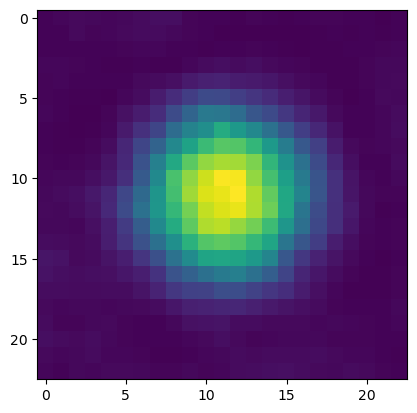

In [167]:
plt.imshow(intens_f)

# Generate massive dataset
#### Will move around spots in the funda and dispersions, probably according to zernike polynomials. Also apply a global shift

In [184]:
import LightPipes as lp
from skimage.restoration import unwrap_phase
#import subpixel shift
from scipy.ndimage import shift


def make_zernike_profile(zernikes):
    n_zernike = len(zernikes)
    size = 200*lp.um

    F=lp.Begin(size=size,labda=800*lp.nm,N=100) # initiate
        

    for Noll in range(1, n_zernike+1):
            (nz, mz) = lp.noll_to_zern(Noll) #converting between int and zernike coeffs
            e_m = 2 if mz == 0 else 1
            A = 1
            F = lp.Zernike(F, nz, mz, size, zernikes[Noll-1] * A, units='lam')
    return unwrap_phase(lp.Phase(F))


def get_zernike_shifts(zernike_coefficients, normalized_relative_peak_locations):
    zernike_profile = make_zernike_profile(zernike_coefficients)
    shift_x, shift_y = np.gradient(zernike_profile)

    x_shifts = nn.functional.grid_sample(torch.tensor(shift_x)[None,None], normalized_relative_peak_locations[None,None])[0,0,0]
    y_shifts = nn.functional.grid_sample(torch.tensor(shift_y)[None,None], normalized_relative_peak_locations[None,None])[0,0,0]

    return x_shifts, y_shifts


def shift_peaks(slice, shifts, relative_peaks, funda_main_peak, minus1_main_peak, plus1_main_peak, border = 20):
    '''
    shift peaks for a single wl slice.
    '''

    warped_slice = slice.clone()

    funda_peaks = (funda_main_peak[None,:] + relative_peaks).astype(int)
    minus1_peaks = (minus1_main_peak[None,:] + relative_peaks).astype(int)
    plus1_peaks = (plus1_main_peak[None,:] + relative_peaks).astype(int)

    for i in range(len(relative_peaks)):
        warped_slice[funda_peaks[i,0]-border:funda_peaks[i,0]+border,funda_peaks[i,1]-border:funda_peaks[i,1]+border] = torch.tensor(shift(slice[funda_peaks[i,0]-border:funda_peaks[i,0]+border,funda_peaks[i,1]-border:funda_peaks[i,1]+border] , shift = (shifts[i,0],shifts[i,1]), order = 1))
        warped_slice[minus1_peaks[i,0]-border:minus1_peaks[i,0]+border,minus1_peaks[i,1]-border:minus1_peaks[i,1]+border] = torch.tensor(shift(slice[minus1_peaks[i,0]-border:minus1_peaks[i,0]+border,minus1_peaks[i,1]-border:minus1_peaks[i,1]+border] , shift = (shifts[i,0],shifts[i,1]), order = 1))
        warped_slice[plus1_peaks[i,0]-border:plus1_peaks[i,0]+border,plus1_peaks[i,1]-border:plus1_peaks[i,1]+border] = torch.tensor(shift(slice[plus1_peaks[i,0]-border:plus1_peaks[i,0]+border,plus1_peaks[i,1]-border:plus1_peaks[i,1]+border] , shift = (shifts[i,0],shifts[i,1]), order = 1))
    
    return warped_slice
        


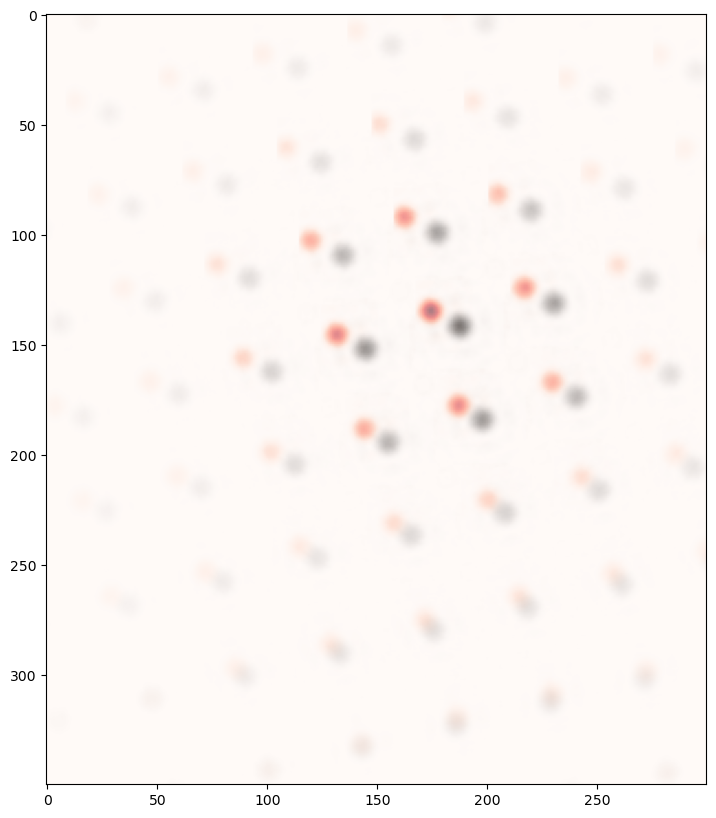

In [248]:
n_zernikes = 10
zernikes = np.zeros((n_zernikes))
zernikes[2] = 1
zernikes = np.random.rand((n_zernikes))

normalized_relative_peaks = torch.tensor((relative_peaks - relative_peaks.min()) / (relative_peaks.max() - relative_peaks.min()))

f = 5.6*lp.mm


shift_x, shift_y = get_zernike_shifts(zernikes,normalized_relative_peaks)
shifts = torch.stack([shift_x,shift_y],dim=1) * 50


shifted = shift_peaks(cube[wl],shifts,relative_peaks,peak_loc_funda,peak_loc_minus1[:,wl],peak_loc_plus1[:,wl])
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(cube[wl,250:600,1000:1300],cmap='gray_r')
ax.imshow(shifted[250:600,1000:1300],alpha=0.5,cmap='Reds')

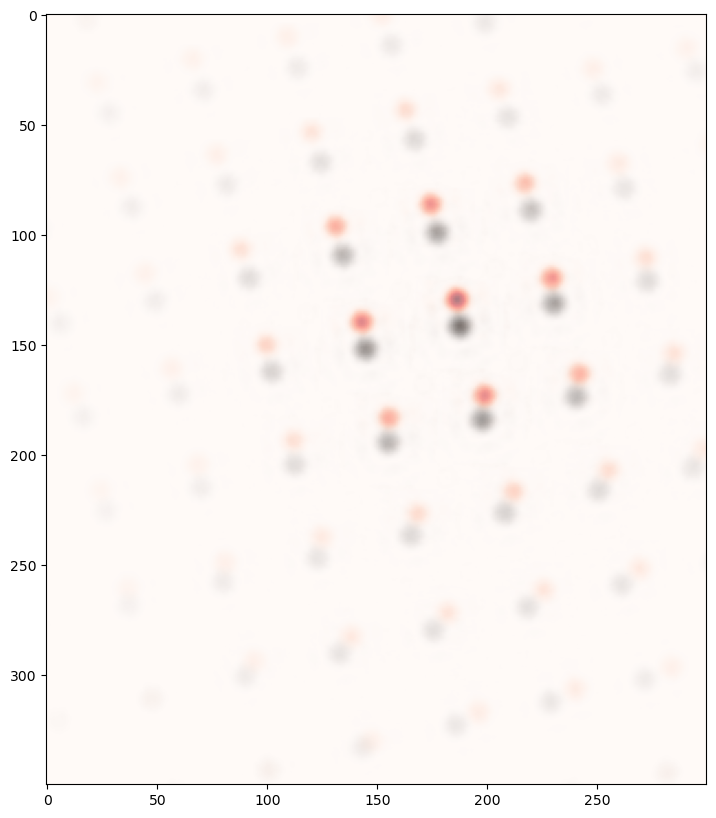